# Practica 2
### Reconocimiento de Patrones
### Kaleb Alfaro Badilla
### Agosto 2018

Base de datos: [https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq)

Esta base de datos está relacionada a la recolección de expresión de genes mensajeros ARN en tejido de diferentes personas. Estos genes mensajeros se tomaron con equipo secuenciador donde la expresión de **20531** genes. Se encuentran **801** instancias de las cuales cada una trae una etiqueta relacionada con una clase de cáncer. El objetivo de este ejercicio es poder proponer un modelo de clasificación utilizando métodos de aprendizaje.


In [160]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.datasets import make_multilabel_classification



db = ["labels.csv","data.csv"];

#Recolección de tipos de cancer
targets = pd.read_csv(db[0],sep=',',usecols=[1]);


t = targets[['Class']].values;


values = np.array(t)

#Codificación de categoría a numeración de las etiquetas
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

# Codificación a one hot encoder 
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
t=onehot_encoded
print(t)

#Importación de atributos de muestras
df = pd.read_csv(db[1],sep=',', usecols=range(1,20532));



features = df.columns.values;
x=df[features].values

# Dataset almacenado en x -> t

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 ..., 
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]
20531


# Análisis exploratorio de los datos

Antes de iniciar los modelos de predicción se hace un análisis exploratorio de esta base de datos. Por conveniencia, se inicia con la reducción dimensional de las muestras, ya que 20531 atributos por muestra es muy difícil manejar computacional y prácticamente. Nótese como con el análisis de componentes principales (PCA), con las primeras 4 principales componentes se puede reconocer tendencias claras en la clasificación. Se puede intuir que con modelos lineales de clasificación se podría lograr buenos resultados. Se grafican las proyecciones P0.1, P1.2, P0.2 y el scatter plot en 3D con la 4ta componente. 

[[-57.44698697  95.41098073  74.30154317 -12.16678588]
 [-16.91943001   0.73247032 -64.07289935  -2.0952971 ]
 [-70.34521785 -19.3033266   20.48824072  48.10290305]
 ..., 
 [ -4.13308968  15.69001389 -22.64445336 -11.98242333]
 [-30.81475747  33.52642255  70.5656358   16.64365272]
 [-22.34455669   4.0523563   32.32787568   5.20113325]]


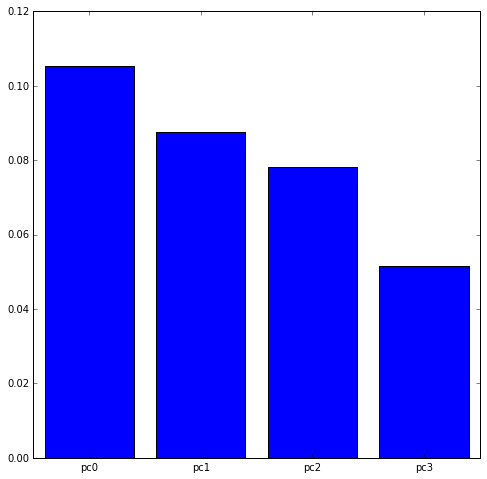

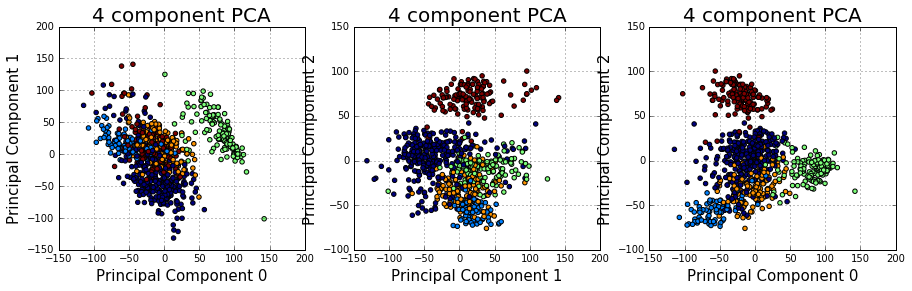

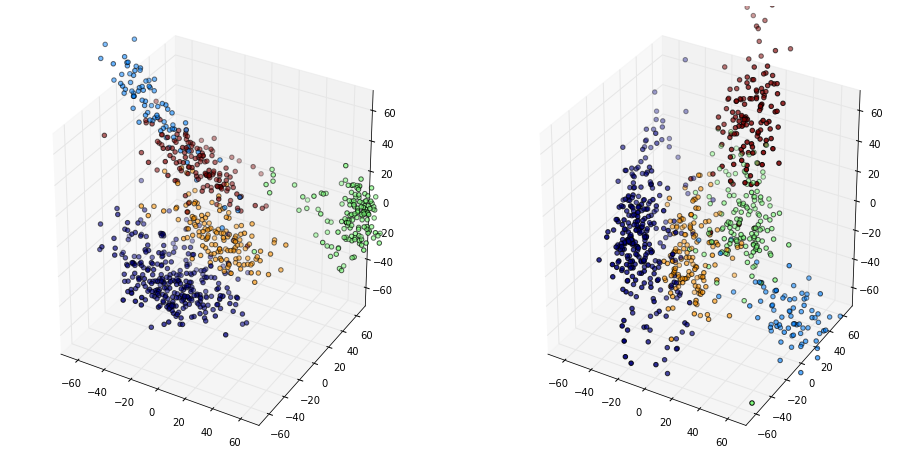

In [165]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc


ss=StandardScaler()

x_s = ss.fit_transform(x)

# Compute PCA
n_components = 4
pca_features = ['pc'+str(i) for i in range(n_components)]


pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x_s)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ind = range(1,n_components+1)
print(principalComponents)
ax.bar(ind,pca.explained_variance_ratio_,align='center')
#ax.plot(ind,pca.explained_variance_ratio_);
ax.set_xticks(ind)
ax.set_xticklabels(pca_features)
plt.show()

colors=[np.argmax(r) for r in t]
    

fig2 = plt.figure(figsize = (15,4))
ax2 = fig2.add_subplot(1,3,1) 
ax2.set_xlabel('Principal Component 0', fontsize = 15)
ax2.set_ylabel('Principal Component 1', fontsize = 15)
ax2.set_title('4 component PCA', fontsize = 20)
ax2.scatter(principalComponents[:,0], principalComponents[:,1],c=colors)

ax3 = fig2.add_subplot(1,3,2) 
ax3.set_xlabel('Principal Component 1', fontsize = 15)
ax3.set_ylabel('Principal Component 2', fontsize = 15)
ax3.set_title('4 component PCA', fontsize = 20)
ax3.scatter(principalComponents[:,1], principalComponents[:,2],c=colors)

ax4 = fig2.add_subplot(1,3,3) 
ax4.set_xlabel('Principal Component 0', fontsize = 15)
ax4.set_ylabel('Principal Component 2', fontsize = 15)
ax4.set_title('4 component PCA', fontsize = 20)
ax4.scatter(principalComponents[:,0], principalComponents[:,2],c=colors)

print()
#ax.legend(targets)
ax2.grid()
ax3.grid()
ax4.grid()

fig3 = plt.figure(figsize = (16,8))
ax5 = fig3.add_subplot(121, projection='3d')

ax5.scatter(principalComponents[:,0], principalComponents[:,1], principalComponents[:,3], c=colors)

ax6 = fig3.add_subplot(122, projection='3d')

ax6.scatter(principalComponents[:,3], principalComponents[:,1], principalComponents[:,2], c=colors)

ax5.set_xlim(-70, 70)
ax5.set_ylim(-70, 70)
ax5.set_zlim(-70, 70)

ax6.set_xlim(-70, 70)
ax6.set_ylim(-70, 70)
ax6.set_zlim(-70, 70)



plt.show()



X, y = principalComponents, t


# Exploración de modelos de aprendizaje

Métodos utilizados

* kNN
* kernel SVM
* Gaussian NB
* Decision Tree
* Random Forest
* Linear SVC
* Passive Aggressive Classifier

Se analizó por cada uno el *Learning rate* y aquellos modelos probabilísticos, el *ROC*.

## Importante

Cabe **resaltar**, no se disponen en la base de datos casos donde no existe categoría de *sin presencia de cáncer*. Esto puede provocar alguna clase de sesgo en la generalización para el caso negativo de todos.

In [152]:
# Aquí se define la función de cálculo del learning rate


from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt




In [153]:
# Aquí se define la función de cálculo del ROC

from scipy import interp
from sklearn.metrics import roc_curve
from sklearn.cross_validation import KFold

def roc_plot(estimator, X, y,ylim=None):

    kf = KFold(n=len(y), n_folds=10)

    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    plt.figure(figsize=(8, 8))
    if ylim is not None:
        plt.ylim(*ylim)
    colors = ['b','g','r','c','m']
    for label in range(5):
        tprs = []
        for i, (train, test) in enumerate(kf):
            model = estimator.fit(X[train], y[train])
            y_score = model.predict_proba(X[test])
            fpr, tpr, _ = roc_curve(y[test][:,label], y_score[label][:,1])
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std


        plt.plot(base_fpr, mean_tprs, colors[label], label='ROC curve of class {0}'
                 ''.format(label))
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=colors[label], alpha=0.05)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axes().set_aspect('equal', 'datalim')
    plt.legend(loc="lower right")
    return plt


# kNN

Este clasificador se observa que rápidamente logra buenos resultados. Esto puede deberse a la aglomeración de las categorías con simetría esférica, por ello las distancias más cercanas son con clases similares. Si se disponen con 100 muestras, este clasificador funcionaría muy bien. En el ROC, este fue el método con mejor rendimiento.


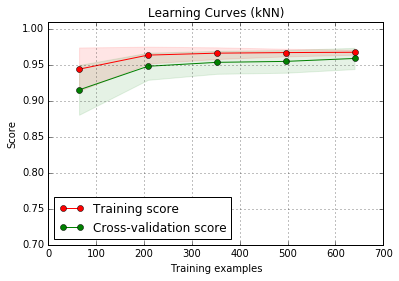

In [154]:
title = "Learning Curves (kNN)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(n_neighbors=5)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)


plt.show()

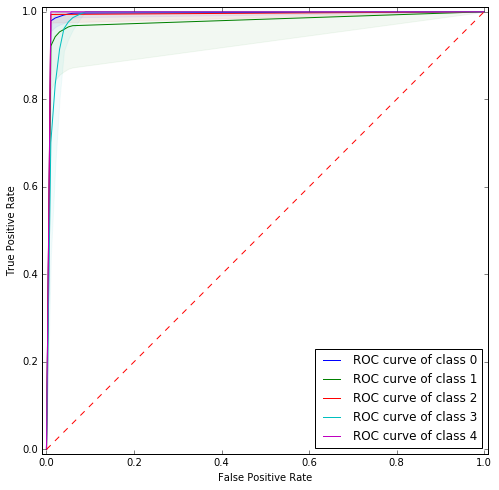

In [138]:
roc_plot(estimator, X, y)
plt.show()

# SVM con kernel RBF

Este clasificador alcanza a saturar en aprendizaje rápidamente con 200 muestras. Para este método, se realizó clasificación *one vs rest*. 

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

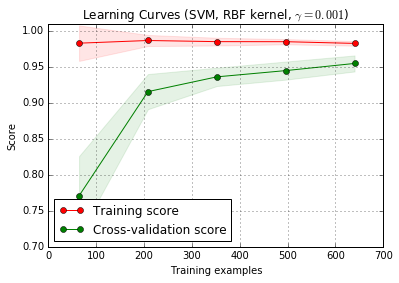

In [167]:
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = OneVsRestClassifier(SVC(kernel='rbf',gamma=0.001))
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)


# Gaussian Naive Bayes 

Este clasificador no se le agregó ninguna clase de *prior* *knowledge*. Su rendimiento como clasificación es buena, pero no tan buena como los clasificadores anteriores.

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

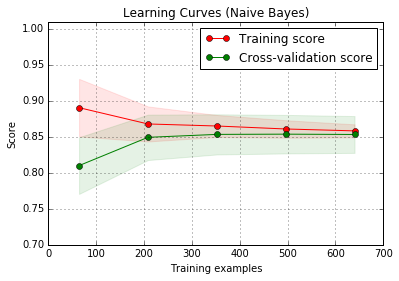

In [140]:
title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = OneVsRestClassifier(GaussianNB())
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


# Decision Tree

Este método se ajusto para una profundidad de 5 preguntas. De otra forma se puede apreciar un *overfitting* o *underfitting*. Vale mencionar que las clases con mayor probabilidad de error (ROC) son diferentes que con el ROC de kNN (un modelo clasifica mejor una clase que otro modelo).

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

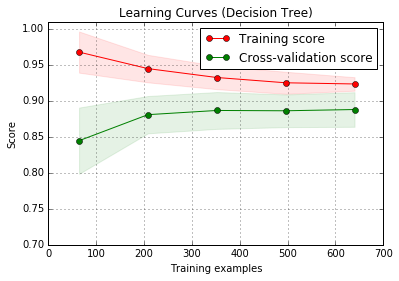

In [141]:
title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(max_depth=5)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


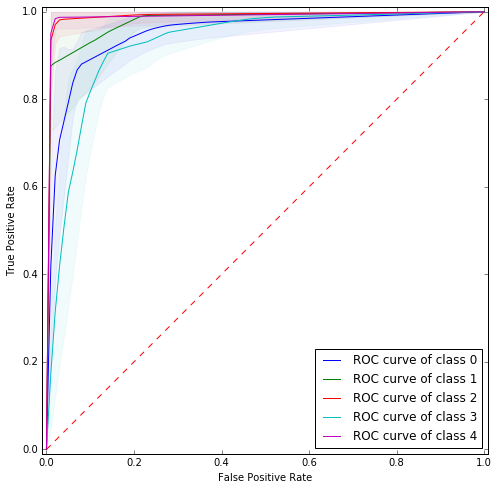

In [142]:
roc_plot(estimator, X, y)
plt.show()

# Random Forest

El ajuste con este método funciona bien con 20 estimadores y profundidad 6 cada uno. Del ROC se puede recuperar que la mayoría de las clases tienen buena precisión.

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

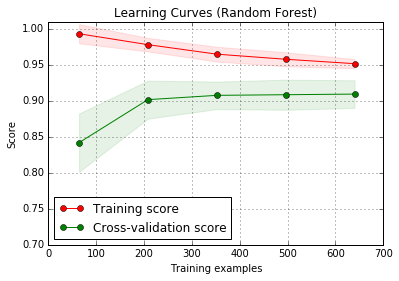

In [173]:
title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(n_estimators=20, max_depth=6)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


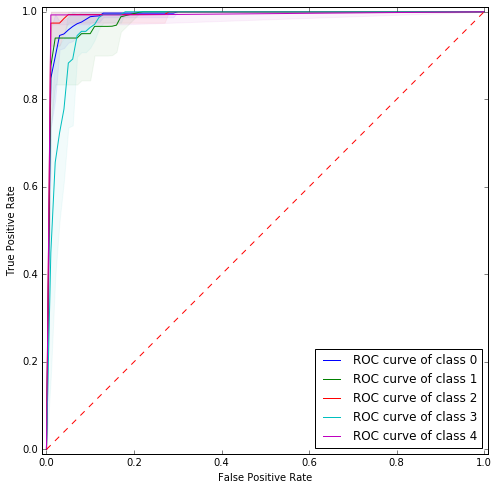

In [144]:
roc_plot(estimator, X, y)
plt.show()

# Linear SVM

En comparación del SVM con kernel. Este tiene resultados buenos pero no tan exitosos como el logrado con kernel rbf.

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

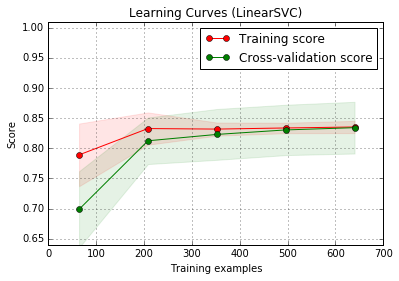

In [188]:
title = "Learning Curves (LinearSVC)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = OneVsRestClassifier(LinearSVC(C=0.01))
plot_learning_curve(estimator, title, X, y, ylim=(0.64, 1.01), cv=cv, n_jobs=4)




# Passive Aggressive Classifier

Este método es utilizado para aprendizaje a gran escala. Se ajustó que por cada epoch hiciera 25 iteraciones. Se escogió el valor de C para que el crecimiento se manteniera con tendencia no acelerada.

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

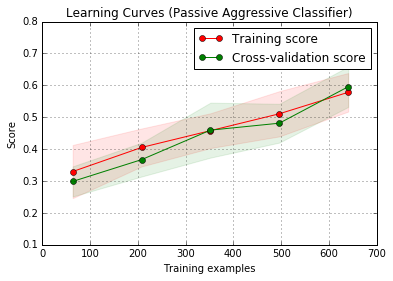

In [204]:
title = "Learning Curves (Passive Aggressive Classifier)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=10)
estimator = OneVsRestClassifier(PassiveAggressiveClassifier(C=0.0001,n_iter=25))
plot_learning_curve(estimator, title, X, y, ylim=(0.1, 0.8), cv=cv, n_jobs=4)


# Conclusiones

1. De acuerdo a estos resultados, el pre procesamiento de los datos utilizando PCA a 4 componentes principales ha sido muy exitoso para mejorar el rendimiento computacional de los algoritmos de clasificación.

2. De los múltiples modelos de aprendizaje, los que obtuvieron mejores resultados a corto plazo y mayoritariamente, fueron kNN y Kernel RBF SVM.